In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from datetime import datetime
import sys


sys.path.insert(1, '/Users/michaelreitman/github/REprofile/scripts') #points to scripts folder
from downloadhomologfastas import downloadhomologfastas 
import arrangeoutputfastas as aof
import fcrl
from analyzecountedAAs import analyzecountedAAs
import plotrepeats as pr



In [5]:
#get date for appending to filenames 
today = datetime.today().strftime('%Y%m%d') 

In [ ]:
#download blast hits 
blast_filepath = "../results/dREhomologs_MR20230710.csv" #points to csv of all homologs that contains a column with the header "gene"
downloadhomologfastas(blast_filepath,overwrite=False)

In [ ]:
#arrange results
results_folder = "../results/hit_DNA_sequences"
aof.arrangefastas(results_folder)

In [ ]:
## Amino Acid counting

#count blast refseq amino acid repeats and save
results_folder = "../results/hit_DNA_sequences"
output_folder = os.path.join("../",results_folder.split("/")[1], "countedAAs_BLAST_refseq")
if not os.path.isdir(output_folder): 
    os.mkdir(output_folder)

fcrl.fcrlwrapper(results_folder, output_folder,MRget=True)

#count BLAST Genbank amino acid repeats and save
results_folder = "../results/BLAST_Genbankfastas_fromEW_20230713"
output_folder = os.path.join("../",results_folder.split("/")[1], "countedAAs","BLAST_genbank")
if not os.path.isdir(output_folder): 
    os.mkdir(output_folder)

fcrl.fcrlwrapper(results_folder, output_folder)

#count structural similarity amino acid repeats and save
results_folder = "../results/Foldseek_aa_fasta_fromEW_20230712"
output_folder = os.path.join("../",results_folder.split("/")[1], "countedAAs" "structural_similarity")
if not os.path.isdir(output_folder): 
    os.mkdir(output_folder)

fcrl.fcrlwrapper(results_folder, output_folder)

In [ ]:
#combine the Refseq and Genbank counts
refseq_folder = "../results/countedAAs/BLAST_refseq"
genbank_folder = "../results/countedAAs/BLAST_genbank"
output_folder = "../results/countedAAs/total"
databases = ["refseq","genbank"]

if not os.path.isdir(output_folder):
    os.mkdir(output_folder)

fcrl.combinecounts(refseq_folder,genbank_folder,output_folder,databases)

#combine the MR's BLAST counts with structural similarity counts
results_folder = "../results/countedAAs/total"
foldseek_folder = "../results/countedAA/structural_similarity"
output_folder = "../results/countedAAs/total"
databases = ["BLAST","structural similarity"]

if not os.path.isdir(output_folder):
    os.mkdir(output_folder)

fcrl.combinecounts(results_folder,foldseek_folder,output_folder,databases)

In [9]:
#combine MR BLAST homology results with structural similarity results
SS_file_path = "../results/homology_results/dREstuct_similarity_fromEW_20230717.tsv"
blast_file_path = "../results/homology_results/dREhomologs_MR20230718.csv"
output_folder = "../results/homology_results"
homolog_df = pd.read_table(SS_file_path)
blast_df = pd.read_csv(blast_file_path)

homolog_df.rename(columns={
    "protid":"Accession",
    "organism.scientificName":"Scientific Name",
    "organism.commonName":"Common Name",
    "sequence.length":"Acc. Len",
    "organism.taxonId":"Taxid",
    },inplace=True)

homolog_df["gene"] = homolog_df["reference"].str.split('_').str[0]
homolog_df.drop_duplicates(inplace=True)
homolog_df.reset_index(inplace=True,drop=True)
#only keep results with TM score >0.2
homolog_df = homolog_df[homolog_df["TM_v_query"]>0.2]

full_df = pd.concat([blast_df ,homolog_df], axis=0, ignore_index=True)
full_df.to_csv(os.path.join(output_folder,"full_results_" + today + ".csv"))

In [ ]:
#analyze the BLAST amino acid repeats and save the results in a new folder
countedAAs_folder = "../results/countedAAs/total"
output_path =  "../results/analyzed_AAcounts"
homology_file_path = "../results/homology_results/full_results20230718.csv"

analyzecountedAAs(input_dir = countedAAs_folder, 
output_path = output_path, 
homology_file_path=homology_file_path 
)

In [ ]:
#plot the amino acid results for each dRE
folder = "../results/analyzed_AAcounts"
pr.plot_analyzed_AAcounts(folder)

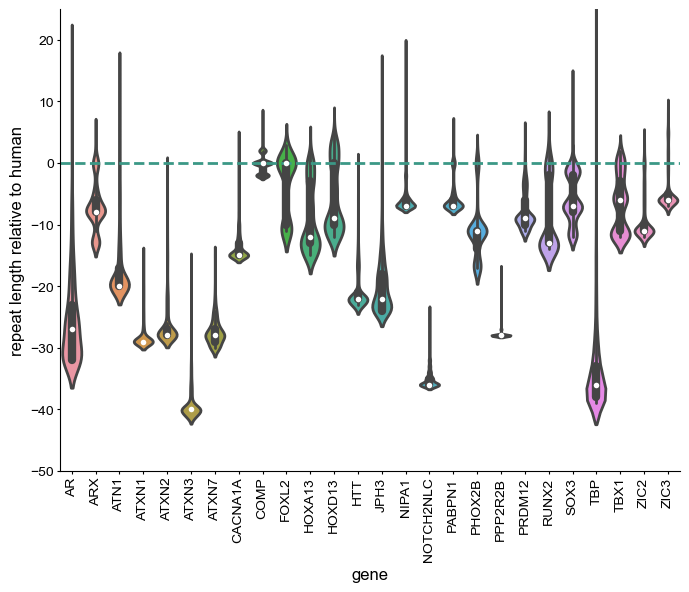

In [7]:
# plot all coding dREs together 
all_AA_reps_path = "../results/analyzed_AAcounts/all_pathologic_AA_repeats.csv"
all_AA_reps = pd.read_csv(all_AA_reps_path)
comparison_metric = "Human Normal Max Delta"

#only one gene per organism
all_AA_reps = all_AA_reps.sort_values('Length', ascending=False).drop_duplicates(subset = ['gene','Scientific Name']).sort_index()
pr.plot_allDRE_pathologicalAA(all_AA_reps,comparison_metric)
plt.ylim([-50,25])

output_folder = "../results/analyzed_AAcounts"


plt.savefig(os.path.join(output_folder,'codingdREs_relmaxhumanrepeats_'+today+'.png'), format='png', dpi=1200)
plt.savefig(os.path.join(output_folder,'codingdREs_relmaxhumanrepeats_'+today+'.pdf'), format='pdf', dpi=1200)

In [ ]:
all_hit_species_path = "../results/analyzed_AAcounts/all_hit_species.csv"
all_hit_species = pd.read_csv(all_hit_species_path)

#filter so each species only has one hit per dRE
all_hit_species = all_hit_species.sort_values('Length', ascending=False).drop_duplicates(subset = ['gene','Scientific Name']).sort_index()

dRE_count_by_species= all_hit_species[['Taxid','Common Name']].value_counts()

bins = range(0,dRE_count_by_species.max(),1)
plt.subplots(figsize=(8,6))
plt.hist(dRE_count_by_species,bins=bins,color="arcadia:marineblue")
plt.xlabel('# of dRE genes with repeats >= the human reference')
plt.ylabel('# of species')

print(dRE_count_by_species.iloc[0:10])

In [ ]:
filename = "../results/taxidcounts_for_treemapping/taxid_ndREhits_forEW" + today + ".csv"
dRE_count_by_species.to_csv(filename)

In [ ]:
temp = all_hit_species.copy()
#For NIPA1 the reference genome contains more repeats than normal max.
# JPH3 assessement is challenging because the repeat happens from an anti-sense transcript
#for HOXD13/ZIC3, many homologs are HOXA13/ZIC2 proteins which have longer repetitive tracts and thus gives false positives
temp = temp[~temp["gene"].str.contains("ZIC3|HOXD13")]

pathogenicmin_dRE_species = temp[temp["Human Pathogenic Min Delta"] >= 0]
normalmax_dRE_species = temp[temp["Human Normal Max Delta"] > 0]

print(pathogenicmin_dRE_species[['Taxid','Scientific Name','Common Name',"gene","Human Pathogenic Min Delta", "Per. Ident","TM_v_query"]].sort_values("gene"))

In [ ]:
healthy_human_max = normalmax_dRE_species[['Taxid','Common Name']].value_counts()
print(healthy_human_max.iloc[0:10])

filename = "../results/taxid_exceeds_healthy_human_max_forEW" + today + ".csv"
healthy_human_max.to_csv(filename)

In [ ]:
mean_lengthZscore = normalmax_dRE_species[["Taxid","Length Zscore"]].groupby("Taxid").mean().sort_values("Length Zscore", ascending=False)
summed_lengthZscore = normalmax_dRE_species[["Taxid","Length Zscore"]].groupby("Taxid").sum().sort_values("Length Zscore", ascending=False)

print(summed_lengthZscore.iloc[0:25])

filename = "../results/taxidcounts_for_treemapping/taxid_exceeds_healthy_max_summed_length_zscore_forEW" + today + ".csv"
summed_lengthZscore.to_csv(filename)

filename = "../results/taxidcounts_for_treemapping/taxid_exceeds_healthy_max_mean_length_zscore_forEW" + today + ".csv"
mean_lengthZscore.to_csv(filename)